## Binary Clasisfication models for occupancy estimation based on $CO_2$

In [85]:
import math
import matplotlib.pylab as pylab
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from Artificial_Neural_Network_Classification import ANN_classify
from Artificial_Neural_Network_Regression import *
from Decision_Tree_Regression import Decision_Tree_Regression
from Get_Data_From_API import get_data_from_API
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (12, 10),
          'axes.labelsize': 'x-large',
          'axes.titlesize': 'x-large',
          'xtick.labelsize': 'medium',
          'ytick.labelsize': 'medium'}
pylab.rcParams.update(params)
import warnings

warnings.filterwarnings('ignore')
np.random.seed(12)

def fit_model(model, X_train, X_test, y_train, y_test):
    features_number = X_train.shape[1]

    y_train = y_train.astype('int')
    y_test = y_test.astype('int')

    model.fit(X_train.reshape(-1, features_number), y_train.reshape(-1, 1))
    prediction = model.predict(X_test.reshape(-1, features_number))
    accuracy = model.score(X_test, y_test)
    MSE = math.sqrt(mean_squared_error(y_test, prediction))
    mean_error = np.mean(np.abs(y_test - prediction))

    confusion_matrix_calculated = confusion_matrix(y_test, prediction)

    return prediction, accuracy, MSE, mean_error, confusion_matrix_calculated


def plot_confusion_matrix(confusion_matrix_calculated,
                          accuracy,
                          model_name):
    matrix_percentage = confusion_matrix_calculated.astype(dtype=np.float32)

    rows = confusion_matrix_calculated.shape[0]
    columns = confusion_matrix_calculated.shape[1]

    for column in range(columns):
        for row in range(rows):
            matrix_percentage[row, column] = matrix_percentage[row, column] / \
                                             np.sum(confusion_matrix_calculated, axis=1)[row]

    sns.heatmap(matrix_percentage, annot=True, fmt=".3f", linewidths=.5, square=True, cmap='Blues_r')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    all_sample_title = f'Accuracy Score for {model_name}: {np.round(accuracy, 4)*100} %'
    plt.title(all_sample_title, size=15)
    plt.show()


def filter_measurements_data(measure, name, business_hours, weekends):
    if business_hours:
        if name == 'co2':
            measure = measure.shift(0)
        measure = measure.between_time('8:00', '19:00')

    if weekends:
        measure = measure[measure.index.dayofweek < 5]

    measure = measure.rename(columns={'value': f'{name}'})

    return measure


def create_dataset(occupancy_data, *args):
    data_set = pd.DataFrame()
    measurements = occupancy_data

    for ar in args:
        data_set = measurements.join(ar, how='inner')
        measurements = data_set

    return data_set

def resample_occupancy(occupancy_binary, sampling_rate, devices_list):
    occupancy_selected_DF = pd.DataFrame(columns=['value'])

    for room in devices_list.iloc[3, :]:
        occupancy_selected = occupancy_binary.loc[occupancy_binary['SpaceName'] == f'{room}', ['Datetime', 'value']]
        date_occupancy_selected = occupancy_selected.set_index('Datetime')
        date_occupancy_selected.index = pd.to_datetime(date_occupancy_selected.index, utc=True)
        date_occupancy_agg = date_occupancy_selected.resample(sampling_rate).min().ffill().astype(int)
        occupancy_selected_DF = occupancy_selected_DF.append(date_occupancy_agg.reset_index(), ignore_index=False)

    occupancy_selected = occupancy_selected_DF.sort_values(by='Datetime')
    occupancy = occupancy_selected.set_index('Datetime')

    occupancy = occupancy.rename(columns={'value': 'occupancy'})
    
    occupancy = occupancy.where(occupancy == 0, 1)

    return occupancy

def prepare_data(data_set, size_window):
    batches_list = []
    labels_list = []
    features_number = data_set.shape[1] - 1
    for idx in range(len(data_set) - size_window - 1):
        batches_list.append(data_set[idx: idx + size_window, 1:features_number + 1])
        labels_list.append(data_set[idx + size_window, 0])
    return np.array(batches_list), np.array(labels_list)


def plot_ROC_curve(X_test, y_test, model, model_name: str):
    y_test = y_test.astype('int')

    # generate a no skill prediction (majority class)
    random_class_probability = [0 for _ in range(len(y_test))]

    predicted_class_probability = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    predicted_class_probability = predicted_class_probability[:, 1]

    random_class_auc = roc_auc_score(y_test, random_class_probability)
    predicted_class_auc = roc_auc_score(y_test, predicted_class_probability)

    # summarize scores
    print('Random: ROC AUC=%.3f' % (random_class_auc))
    print(f'{model_name}: ROC AUC=%.3f' % (predicted_class_auc))

    # calculate roc curves
    random_class_fpr, random_class_tpr, _ = roc_curve(y_test, random_class_probability)
    predicted_class_fpr, predicted_class_tpr, _ = roc_curve(y_test, predicted_class_probability)
    # plot the roc curve for the model
    pyplot.plot(random_class_fpr, random_class_tpr, linestyle='--', label='Random')
    pyplot.plot(predicted_class_fpr, predicted_class_tpr, marker='.', label='Predicted')
    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    plt.title(f'ROC curve for {model_name}', size=15)
    pyplot.legend()
    pyplot.show()

## Occupancy estimation

Two models will be applied to the problem of occupancy estimation:

* Classification problem - Room is occupied or not
* Regression problem - How many people are in the room

In [36]:
start_date = "2019-11-01 07:00"
end_date = "2019-12-19 07:00"
freq = 6
sampling_rate = '30T'

In [37]:
devices_list_full = pd.DataFrame([['OLY-A-413', 'OLY-A-414', 'OLY-A-415', 'OLY-A-416', 'OLY-A-417'],
                                 ['9033', '9049', '8989', '7675', '7663'],
                                 ['ROOM 1', 'ROOM 2', 'ROOM 3', 'ROOM 4', 'ROOM 5'],
                                 ['Room 4.1', 'Room 4.2', 'Room 4.3', 'Room 4.4', 'Room 4.5']])
devices_list_room_1 = pd.DataFrame([['OLY-A-413'],
                                    ['9033'],
                                    ['ROOM 1'],
                                    ['Room 4.1']])
devices_list_room_2 = pd.DataFrame([['OLY-A-414'],
                                    ['9049'],
                                    ['ROOM 2'],
                                    ['Room 4.2']])
devices_list_room_3 = pd.DataFrame([['OLY-A-415'],
                                    ['8989'],
                                    ['ROOM 3'],
                                    ['Room 4.3']])
devices_list_room_4 = pd.DataFrame([['OLY-A-416'],
                                    ['7675'],
                                    ['ROOM 4'],
                                    ['Room 4.4']])
devices_list_room_5 = pd.DataFrame([['OLY-A-417'],
                                    ['7663'],
                                    ['ROOM 5'],
                                    ['Room 4.5']])

devices_list = devices_list_room_4

In [38]:
occupancy_binary_partN1 = pd.read_csv('data_sets/binary_occupancy_Nov1.csv')
occupancy_binary_partN2 = pd.read_csv('data_sets/binary_occupancy_Nov2.csv')
occupancy_binary_partD1 = pd.read_csv('data_sets/binary_occupancy_Dec1.csv')
occupancy_binary_partD2 = pd.read_csv('data_sets/binary_occupancy_Dec2.csv')

occupancy_binary = occupancy_binary_partN1.append([occupancy_binary_partN2, occupancy_binary_partD1,
                                                   occupancy_binary_partD2])

occupancy = resample_occupancy(occupancy_binary, sampling_rate, devices_list)

In [60]:
load = get_data_from_API(start_date, end_date, freq, devices_list, sampling_rate)

co2, noise, humidity, temperature = load.get_awair_data()

In [65]:
co2 = pd.DataFrame(co2["value"])

Setting a boolean value to True means that certain days and times will be excluded from a dataset

In [66]:
business_hours = False
weekends = True

co2 = filter_measurements_data(co2, 'co2', business_hours, weekends)
noise = filter_measurements_data(noise, 'noise', business_hours, weekends)
humidity = filter_measurements_data(humidity, 'humidity', business_hours, weekends)
temperature = filter_measurements_data(temperature, 'temperature', business_hours, weekends)

In [67]:
data = create_dataset(occupancy, co2, noise)

### Visualize relationship for 2 day

1 - room occupied
0 - room not occupied


Text(0.5, 1, 'Occupancy vs CO_2')

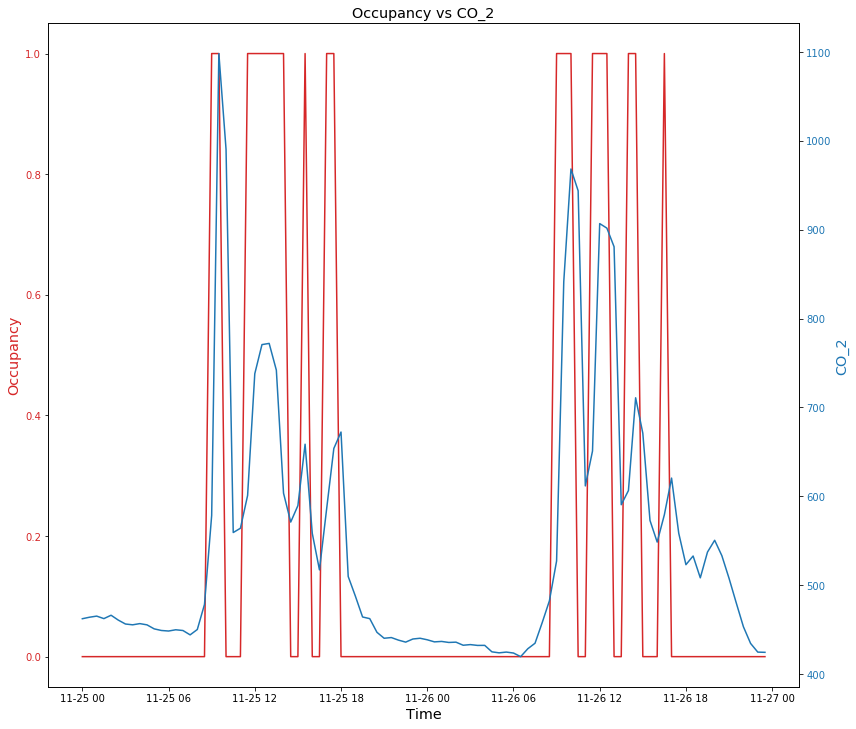

In [69]:
data_cut = (data.loc[(data.index.day==25) & (data.index.month==11)]).append(data.loc[(data.index.day==26) & (data.index.month==11)])

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Time')
ax1.set_ylabel('Occupancy', color=color)

ax1.plot(data_cut['occupancy'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('CO_2', color=color)

ax2.plot(data_cut['co2'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title(f'Occupancy vs CO_2')

#
# ax2.set_ylabel('Noise', color=color)
#
# ax2.plot(data['noise'], color=color)
# ax2.tick_params(axis='y', labelcolor=color)

# fig.tight_layout()
# plt.title(f'Occupancy vs Noise')

## How imbalanced is the dataset?

Text(0.5, 1.0, 'Dataset imbalance visualization')

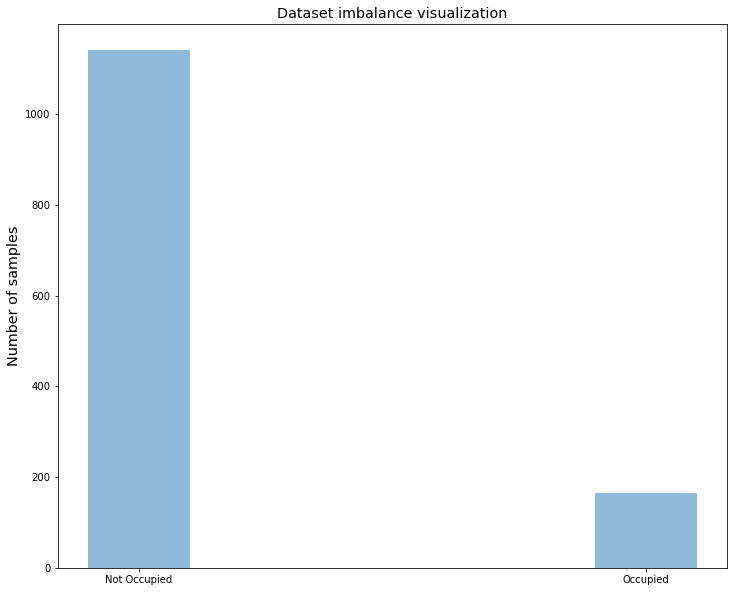

In [70]:
count_class = data['occupancy'].value_counts()

plt.bar(count_class.index, [count_class.loc[0], count_class.loc[1]], width=0.2, align='center', alpha=0.5)

plt.xticks(count_class.index, ['Not Occupied', 'Occupied'])

plt.ylabel('Number of samples')
plt.title('Dataset imbalance visualization')

Scale and normalize feature data

In [72]:
scaler = preprocessing.StandardScaler()
data = data.to_numpy()
no_features = data.shape[1] - 1
data[:, 1:no_features + 1] = scaler.fit_transform(data[:, 1:no_features + 1])

In [73]:
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(data[:, 1:no_features + 1], data[:, 0],
                                                                            test_size=1 / 3, random_state=42,
                                                                            shuffle=True)

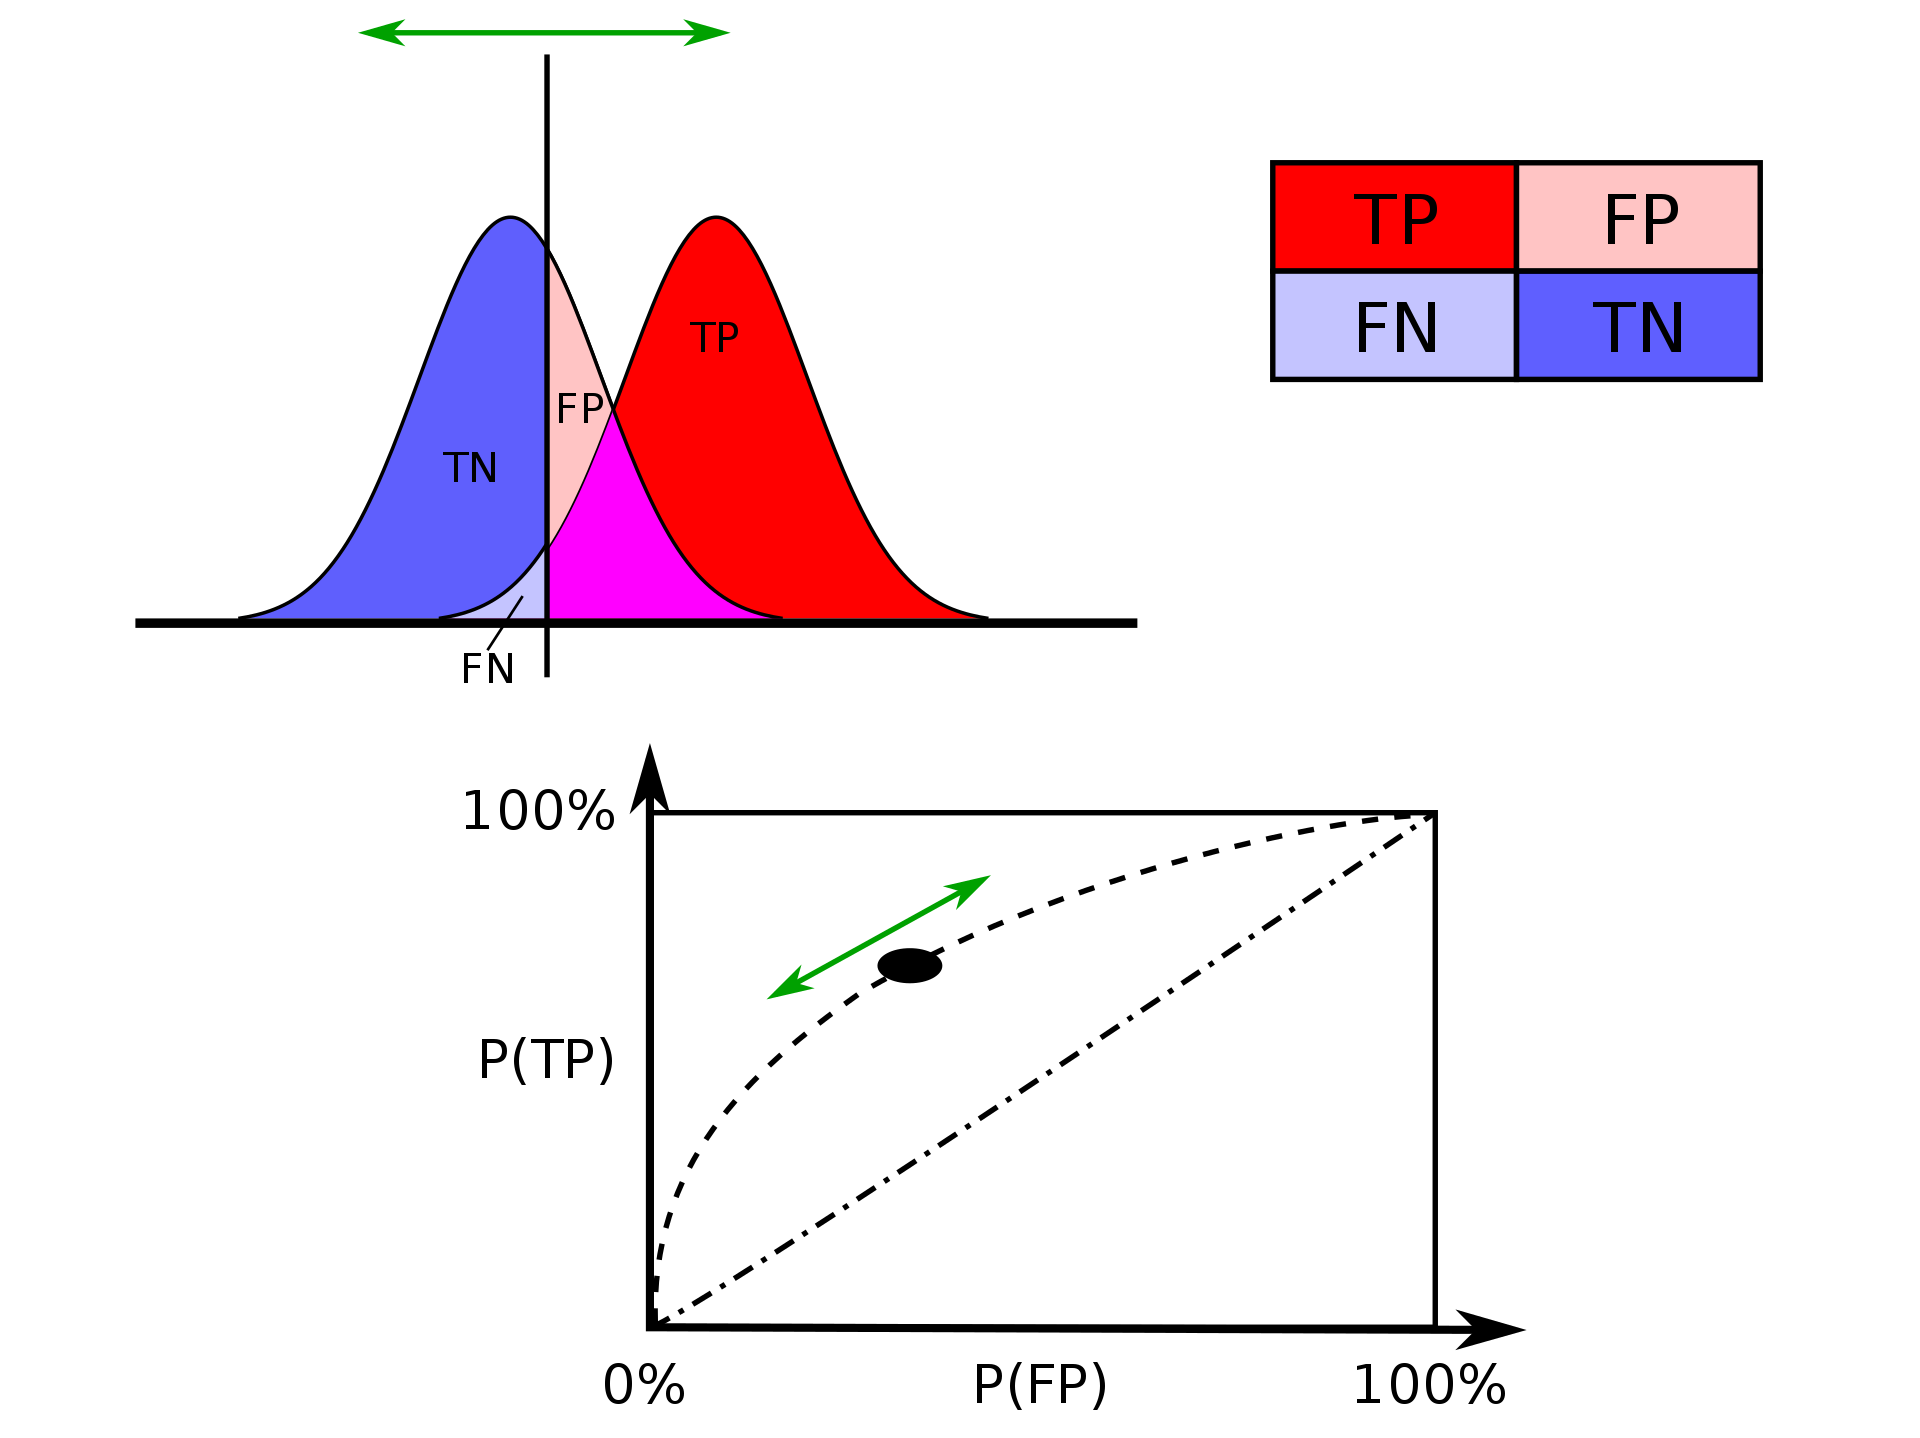

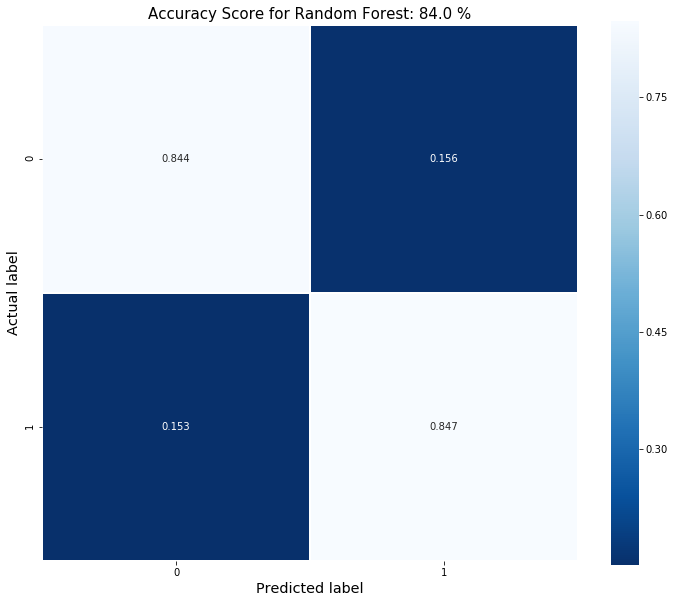

In [74]:
model_Random_Forest = RandomForestClassifier(n_estimators=500, max_depth=5, random_state=0, class_weight='balanced')

prediction_Random_Forest, accuracy_Random_Forest, MSE_Random_Forest, mean_error_Random_Forest, cm_Random_Forest = \
    fit_model(model_Random_Forest, X_train_class, X_test_class, y_train_class, y_test_class)

plot_confusion_matrix(cm_Random_Forest, np.round(accuracy_Random_Forest, 2), 'Random Forest')

Random: ROC AUC=0.500
Random Forest: ROC AUC=0.920


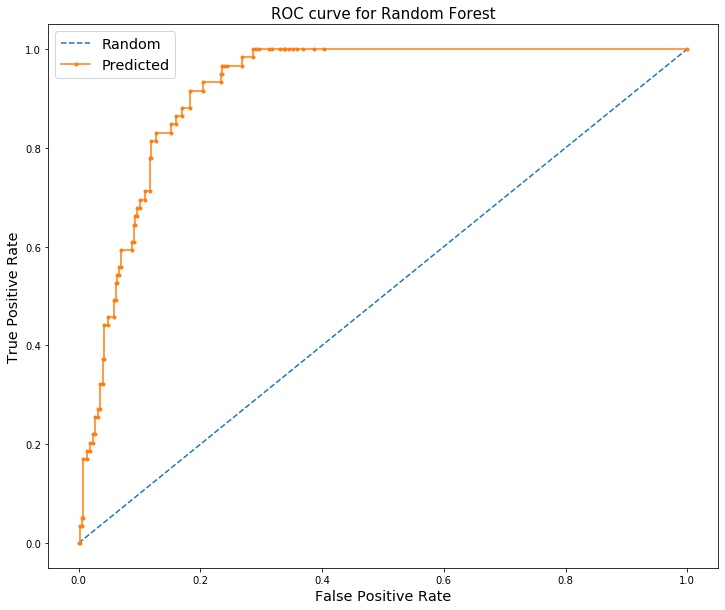

In [75]:
plot_ROC_curve(X_test_class, y_test_class, model_Random_Forest, 'Random Forest')

In [76]:
y_test_class = y_test_class.astype('int')

print(classification_report(y_test_class, prediction_Random_Forest))

              precision    recall  f1-score   support

           0       0.97      0.84      0.90       377
           1       0.46      0.85      0.60        59

    accuracy                           0.84       436
   macro avg       0.72      0.85      0.75       436
weighted avg       0.90      0.84      0.86       436



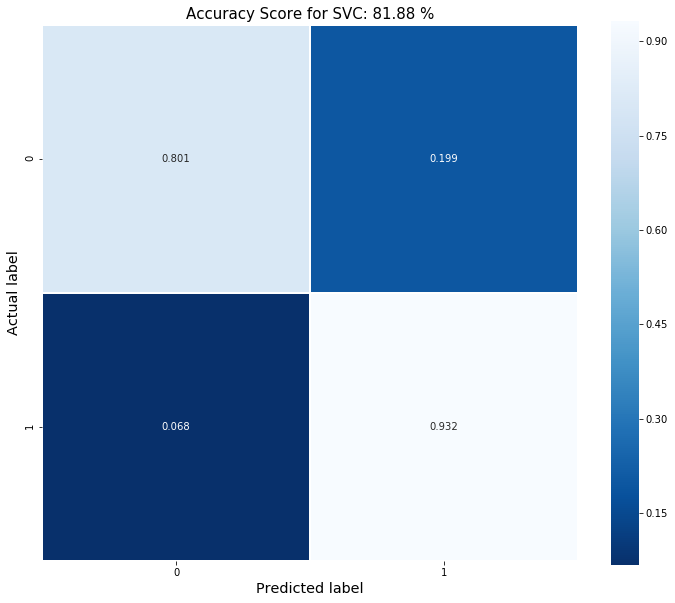

In [77]:
model_SVC = SVC(C=90, kernel='rbf', class_weight='balanced', gamma='auto', probability=True)

prediction_SVC, accuracy_SVC, MSE_SVC, mean_error_SVC, cm_SVC = \
    fit_model(model_SVC, X_train_class, X_test_class, y_train_class, y_test_class)

plot_confusion_matrix(cm_SVC, accuracy_SVC, 'SVC')

Random: ROC AUC=0.500
SVC: ROC AUC=0.903


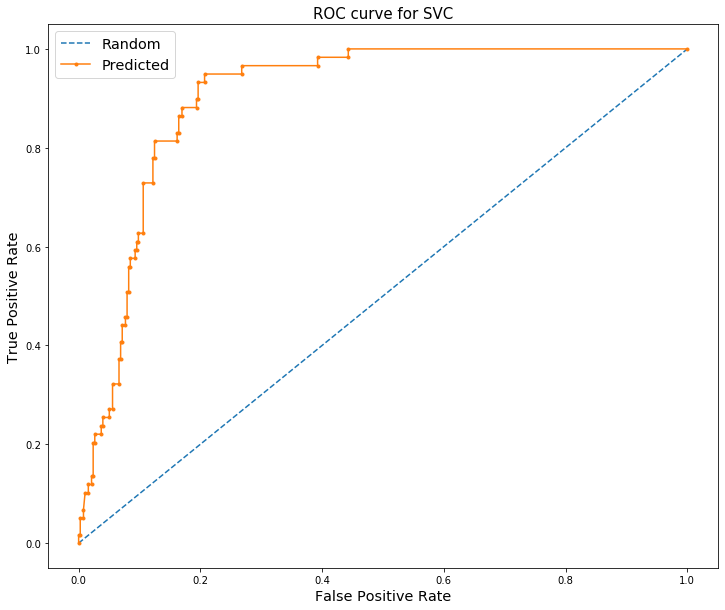

In [78]:
plot_ROC_curve(X_test_class, y_test_class, model_SVC, 'SVC')

In [79]:
print(classification_report(y_test_class, prediction_SVC))

              precision    recall  f1-score   support

           0       0.99      0.80      0.88       377
           1       0.42      0.93      0.58        59

    accuracy                           0.82       436
   macro avg       0.71      0.87      0.73       436
weighted avg       0.91      0.82      0.84       436



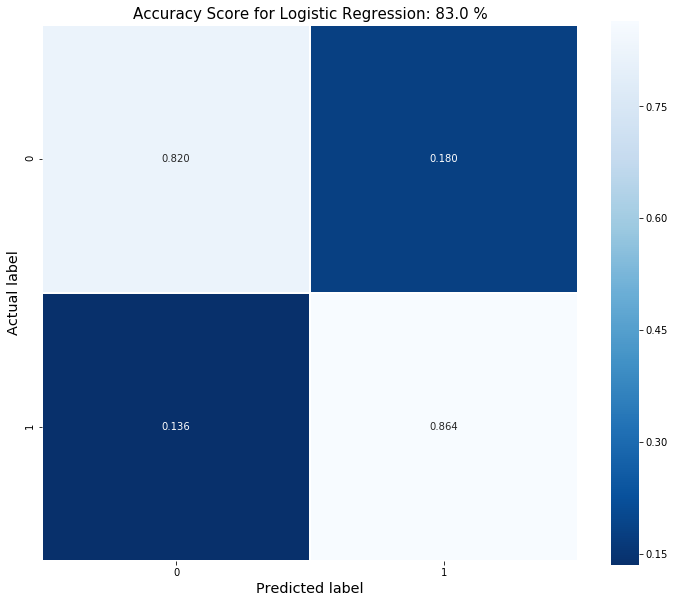

In [80]:
log_regres = LogisticRegression(C=1, penalty='l2', solver='saga', l1_ratio=0.1, random_state=0, class_weight='balanced')
# log_regres = LogisticRegression(C=0.0001, penalty='l2', solver='saga', l1_ratio=0.1, random_state=0, class_weight='balanced')

prediction_log_regres, accuracy_log_regres, MSE_log_regres, mean_error_log_regres, cm_log_regres = \
    fit_model(log_regres, X_train_class, X_test_class, y_train_class, y_test_class)

plot_confusion_matrix(cm_log_regres, np.round(accuracy_log_regres, 2), 'Logistic Regression')

Random: ROC AUC=0.500
Logistic Regression: ROC AUC=0.914


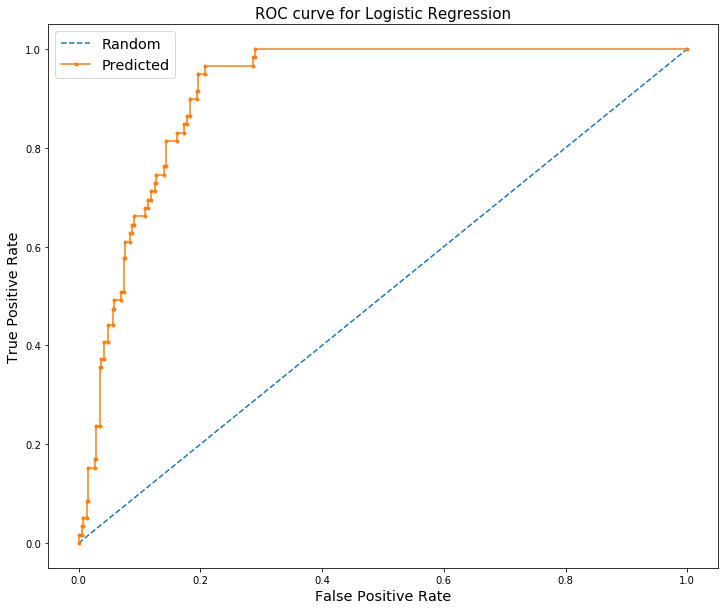

In [81]:
plot_ROC_curve(X_test_class, y_test_class, log_regres, 'Logistic Regression')


In [82]:
print(classification_report(y_test_class, prediction_log_regres))

              precision    recall  f1-score   support

           0       0.97      0.82      0.89       377
           1       0.43      0.86      0.57        59

    accuracy                           0.83       436
   macro avg       0.70      0.84      0.73       436
weighted avg       0.90      0.83      0.85       436



In [89]:
number_of_epochs = 500
window_size = 32
batch_size = 64
number_of_nodes = 100
regularization_penalty = 0.0001

metrics_list = [
    metrics.BinaryAccuracy(name='accuracy'),
    metrics.Precision(name='precision'),
    metrics.Recall(name='recall'),
    metrics.AUC(name='auc'),
]

batches, labels = prepare_data(data, window_size)

X_train, X_test, y_train, y_test = train_test_split(batches, labels, test_size=1 / 3, random_state=42)

accuracy_ANN, prediction_ANN, cm_ANN, model_ANN = ANN_classify(X_train, X_test, y_train, y_test, number_of_nodes, number_of_epochs,
                                                    window_size, metrics_list, regularization_penalty)

RuntimeError: Attempting to capture an EagerTensor without building a function.

In [84]:
metrics_results = pd.DataFrame([accuracy_ANN], columns=['loss', 'TP', 'FP', 'TN', 'FN', 'accuracy', 'precision',
                                                        'recall', 'AUC'])
metrics_results

NameError: name 'accuracy_ANN' is not defined

In [ ]:
plot_confusion_matrix(cm_ANN, metrics_results.iloc[0, 6], 'Neural Network')

In [ ]:
print(classification_report(y_test, prediction_ANN))

In [ ]:
plot_ROC_curve(X_test, y_test, model_ANN, 'Neural Network')

In [ ]:
cm_ANN